In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

from os.path import exists

import gdown
import zipfile

### Data Loading

In [2]:
# # Download the data if it doesn't exists locally already
# def download_device_data(url:str, filename:str):
#     file_exists = exists('../data/' + filename) 
#     if file_exists==False:
#         output = '../data/' + filename + '.zip'
#         gdown.download(url, output, quiet=False, fuzzy=True)

#         # Unzip the data 
#         with zipfile.ZipFile(output, 'r') as zip_ref:
#             zip_ref.extractall('../data/')
#     return None

In [ ]:
# urls = ['https://drive.google.com/file/d/1QC6afqmWSHNpgsoe7j7g4E3YaYoHqeIt/view?usp=sharing', 
#         'https://drive.google.com/file/d/1Y_m2Awl9161Rs-7xiXbQKV7NOsDI6DI5/view?usp=sharing', 
#         'https://drive.google.com/file/d/1-mayhsGwpSnSHQYDRUDT2bY9EFSrrpOZ/view?usp=sharing',
#         'https://drive.google.com/file/d/10USDOONYDPo8BAY46qhQOAPdpwnC1S4D/view?usp=sharing'
#        ]
# filenames = ['devices1.csv',
#             'devices2.csv',
#             'devices3.csv',
#             'devices4.csv',
#            ]
# for url, filename in zip(urls, filenames):
#     download_device_data(url, filename)

In [83]:
def make_plot(battery_id, column, df):
    x = df.loc[df["battery_id"] == battery_id].index
    y = df[column].loc[df["battery_id"] == battery_id]
    plt.plot(x, y)
    plt.ylabel(column)
    plt.title('battery_id = %s'%battery_id)

In [21]:
# Load times series csv file
# Each file contains data from approximately 50 devices

ts1_df = pd.read_csv('..\data/devices1.csv')
ts2_df = pd.read_csv('..\data/devices2.csv')
ts3_df = pd.read_csv('..\data/devices3.csv')
ts4_df = pd.read_csv('..\data/devices4.csv')
ts_df = pd.concat([ts1_df, ts2_df, ts3_df, ts4_df], axis = 0, ignore_index = True)

In [87]:
# Examination - print some parameters.
print('ts_df.shape: ', ts_df.shape)
print('max_voltage: ', ts_df["battery_voltage"].max())
print('min_voltage: ', ts_df["battery_voltage"].min())
# The convention here is that charging currents are negative.
print('max charging current: ', ts_df["current"].loc[ts_df["current"] < 0].min())
print('min charging current: ', ts_df["current"].loc[ts_df["current"] < 0].max())
print('max discharging current: ', ts_df["current"].loc[ts_df["current"] >= 0].max())
print('min discharging current: ', ts_df["current"].loc[ts_df["current"] >= 0].min())

ts_df.shape:  (20890508, 11)
max_voltage:  8.215
min_voltage:  4.735
max charging current:  -3.168
min charging current:  -0.0019999999999997
max discharging current:  2.6180000000000003
min discharging current:  0.0


In [100]:
# Extract temperature, current and power features at SoC bins.
# Specifically extract max, min, and mean values.
from scipy.stats import binned_statistic
def binned_by_SoC (battery_id, param, df, statistic = 'mean'):
    x = df["state_of_charge_percent"].loc[df["battery_id"]==battery_id] # Data to be binned
    values = df["temperature"].loc[df["battery_id"]==battery_id] # Data on which the statistic is computed
    binned_values, bin_edges, _ = binned_statistic(x, values, statistic = statistic, bins=[0,10,20,30,40,50,60,70,80,90,100])
    return binned_values, bin_edges

# temp_bin_means, temp_bin_edges = binned_by_SoC (0, "temperature", df = ts_df, statistic = 'mean')

temp_features_min = np.empty((200,10))
temp_features_min[:] = np.NaN
temp_features_max = np.empty((200,10))
temp_features_max[:] = np.NaN
temp_features_mean = np.empty((200,10))
temp_features_mean[:] = np.NaN

for battery in range (0,200):
    temp_features_min[battery, :], _ = binned_by_SoC (battery, "temperature", df = ts_df, statistic = 'min')
    temp_features_max[battery, :], _ = binned_by_SoC (battery, "temperature", df = ts_df, statistic = 'max')
    temp_features_mean[battery, :], _ = binned_by_SoC (battery, "temperature", df = ts_df, statistic = 'mean')
# cols = ['battery_id','temp_mean_0to10SoC', 'temp_mean_10to20SoC', 'temp_mean_20to30SoC', 'temp_mean_30to40SoC', 'temp_mean_40to50SoC', 'temp_mean_50to60SoC', 'temp_mean_60to70SoC',
#     'temp_mean_70to80SoC', 'temp_mean_80to90SoC', 'temp_mean_90to100SoC']
# df_features = pd.Dataframe(columns = cols)
# xticks = ['0','10','20','30','40','50','60','70','80','90']
# plt.bar(temp_bin_edges[:-1], temp_bin_means, align = 'edge', width = 9.5)#, tick_label=xticks)

In [104]:
cols = ['0to10SoC', '10to20SoC', '20to30SoC', '30to40SoC', '40to50SoC', '50to60SoC', '60to70SoC',
        '70to80SoC', '80to90SoC', '90to100SoC']
df_temp_features_min = pd.DataFrame(temp_features_min, columns = cols)
df_temp_features_max = pd.DataFrame(temp_features_max, columns = cols)
df_temp_features_mean = pd.DataFrame(temp_features_mean, columns = cols)

In [105]:
df_temp_features_min

,0to10SoC,10to20SoC,20to30SoC,30to40SoC,40to50SoC,50to60SoC,60to70SoC,70to80SoC,80to90SoC,90to100SoC
0,NaN,NaN,21.723507,21.057450,21.989014,21.297780,21.750973,22.796979,22.888533,22.785534
1,NaN,NaN,22.538338,23.440146,23.350881,23.492790,23.517967,23.733120,24.655528,22.066835
2,NaN,23.055619,22.263676,24.000916,23.936828,22.288853,21.947814,21.419089,20.748455,21.071183
3,NaN,24.151980,23.822385,24.266423,24.454108,24.479286,25.266651,25.626001,26.303502,25.042344
4,NaN,NaN,22.446784,22.577249,22.991531,23.760586,23.836118,24.303044,25.140764,23.925383
...,...,...,...,...,...,...,...,...,...,...
195,NaN,NaN,22.394141,22.249943,22.888533,22.394141,23.453880,23.440146,23.772030,22.888533
196,NaN,NaN,26.205081,24.554818,24.605173,23.847562,23.987182,23.822385,23.517967,23.746853
197,NaN,NaN,21.458000,22.014191,22.133211,21.084916,21.391623,22.355230,22.810712,22.094301
198,NaN,22.966354,22.590982,22.977798,22.368963,22.563516,22.302586,23.657588,24.227512,22.952621


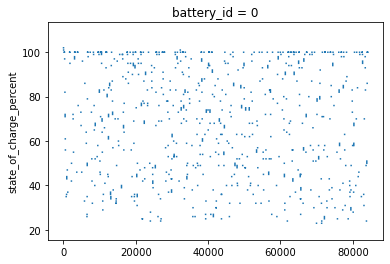

In [61]:
make_plot(0, 'state_of_charge_percent', ts_df)

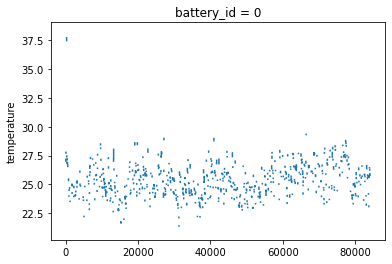

In [63]:
make_plot(0, 'temperature', ts_df)

In [71]:
temp_bin_edges

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

#### Data Frame Columns

 `current_out`: current withdrawn from the box by the consumer <br>
 `current_in`: current supplied to the box from the solar panel <br>
 `current`: `current_out` - `current-in` --> net current that goes in or out of the battery <br>
 `temperature`: temperature in deg C <br>
 `timestamp`: YYYY-MM-DD HH:MM:SS <br>
 `panel_voltage`: voltage of the battery in V <br>
 `state_of_charge_percent`: state of charge of the battery in percent <br>
 `battery_id`: unique identifier of the battery <br>

In [22]:
ts_df.loc[ts_df["battery_id"]==0].loc[:1000,:]

,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,timestamp,usb_current,voltage,battery_id
0,7.090,-2.542,2.544,0.002,7.240,NaN,NaN,2021-03-02 06:33:24,0.002,7.185,0
1,7.100,-2.548,2.550,0.002,7.245,NaN,NaN,2021-03-02 06:35:24,0.002,7.190,0
2,7.095,-2.472,2.474,0.002,7.275,NaN,NaN,2021-03-02 06:37:24,0.002,7.215,0
3,7.070,-2.232,2.236,0.004,7.370,NaN,NaN,2021-03-02 06:39:24,0.002,7.290,0
4,7.075,-2.276,2.278,0.002,7.350,100.0,28.287938,2021-03-02 06:41:24,0.002,7.280,0
...,...,...,...,...,...,...,...,...,...,...,...
996,6.675,-0.192,0.200,0.008,6.680,NaN,NaN,2021-03-03 15:22:55,0.002,6.695,0
997,6.675,-0.182,0.190,0.008,6.675,54.0,24.479286,2021-03-03 15:23:52,0.002,6.695,0
998,6.675,-0.174,0.182,0.008,6.675,NaN,NaN,2021-03-03 15:25:46,0.002,6.695,0
999,6.670,-0.162,0.170,0.008,6.670,NaN,NaN,2021-03-03 15:27:46,0.002,6.690,0


In [91]:
ts_df.tail()

,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,timestamp,usb_current,voltage,battery_id
20890503,6.745,-1.054,1.062,0.008,6.810,NaN,NaN,2021-07-05 07:25:36,0.002,6.815,199
20890504,6.745,-1.070,1.078,0.008,6.810,NaN,NaN,2021-07-05 07:27:36,0.000,6.820,199
20890505,6.750,-1.090,1.098,0.008,6.815,NaN,NaN,2021-07-05 07:29:36,0.000,6.820,199
20890506,6.750,-1.102,1.110,0.008,6.820,40.0,27.729458,2021-07-05 07:31:36,0.000,6.825,199
20890507,6.755,-1.120,1.128,0.008,6.820,NaN,NaN,2021-07-05 07:33:36,0.000,6.825,199


### Plotting

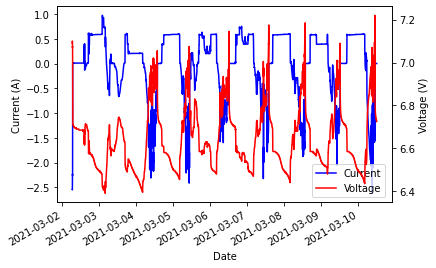

In [6]:
# Basic plot of the data

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

start_pidx = 0 
end_pidx = 6000 

dates = matplotlib.dates.date2num(ts_df.loc[ts_df["battery_id"]==0].loc[start_pidx:end_pidx, "timestamp"])
current = ts_df.loc[ts_df["battery_id"]==0].loc[start_pidx:end_pidx, "current"]
voltage = ts_df.loc[ts_df["battery_id"]==0].loc[start_pidx:end_pidx, "battery_voltage"]

fig, host = plt.subplots()
par1 = host.twinx()

p1, = host.plot(dates, current, 'b', label='Current')
p2, = par1.plot(dates, voltage, 'r', label='Voltage')

host.set_ylabel('Current (A)')
par1.set_ylabel('Voltage (V)')
host.set_xlabel('Date')

host.xaxis.set_major_locator(xtick_locator)
host.xaxis.set_major_formatter(xtick_formatter)
fig.autofmt_xdate()

lines = [p1, p2]
host.legend(lines, [l.get_label() for l in lines], loc=1, bbox_to_anchor=(0.995,0.22))
fig.show()